# TODO: 
- prepare small dataset
- different augmentation on small dataset
- run the train_validation function on small dataset and augmented small dataset
(might take around 12 min to finish the loop)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [2]:
seed = 32
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

In [3]:
train_data = datasets.CIFAR10(
    root="complete-data",
    train=True,
    download=True,
    transform=ToTensor()
)
#train_data[i] is a tuple(3*32*32, label) (C,H,W)
test_data = datasets.CIFAR10(
    root="complete-data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


## Visualize the dataset

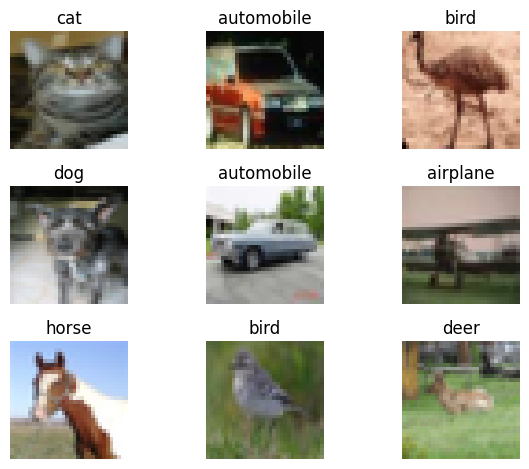

In [5]:
labels={
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def visualize_dataset(imgs):
    fig, axes = plt.subplots(3, 3)
    axes=axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[0].permute(1,2,0)) #H,W,C
        axes[i].axis('off')
        axes[i].set_title(labels[img[1]])
    plt.tight_layout()
    plt.show()

rand_indices=np.random.randint(0,len(train_data),size=9)
rand_imgs=[train_data[i] for i in rand_indices]
visualize_dataset(rand_imgs)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H=train_data[0][0].shape[1]
W=train_data[0][0].shape[2]

CAT_NUM=10
lr=0.001
batch_size=128
epochs=50

## DataLoader

In [7]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Dataset(small)

# Dataset (augmented)
- random crop
- random rotations
- adding gaussian noise
- different combinations of them

# CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self,H,W,cat_num):
        super().__init__()
        
        #self.convs=nn.ModuleList([nn.Conv2d(3,16,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [16,32，64]]) #128
        self.convs=nn.ModuleList([nn.Conv2d(3,32,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [32,64]])
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(2,2)
        self.flatten=nn.Flatten(1,-1)
        self.fc1=nn.Linear(int(128*H*W/(4**3)),256)
        #self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(256,cat_num)
        
        
    def forward(self,x):#x is (batch,channel,H,W)
        for conv in self.convs:
            #print(x.shape)
            x=conv(x)
            
            x=self.relu(x)
            x=self.maxpool(x)
        x=self.flatten(x)
        x=self.relu(self.fc1(x))
        #x=self.relu(self.fc2(x))
        x=self.fc3(x)
        return x


In [9]:

model=CNN(H,W,CAT_NUM).to(device)
print(model)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr)

CNN(
  (convs): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# Training

In [11]:
def train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model):
    train_losses=[]
    val_losses=[]
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss=0.0
        model.train()
        for data in train_dataloader:
            
            #data=data.to(device)
            img,label=data
            img=img.to(device)
            label=label.to(device)
        

            optimizer.zero_grad()
            output = model(img)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(train_dataloader):
                img,label=data
                img=img.to(device)
                label=label.to(device)
                
                output=model(img)
                loss=loss_function(output,label)
                val_loss+=loss.item()*img.size(0)

        #average loss
        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(test_dataloader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)        
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.show()



# Result

## Complete dataset (large)
performs well

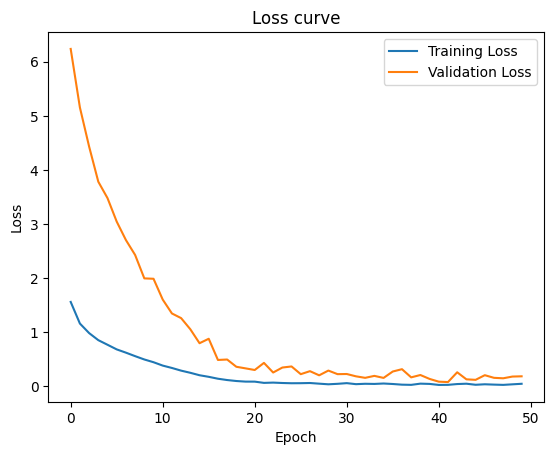

In [12]:
train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model)

## Small dataset
overfitting

## Different augmentations on small dataset